In [4]:
pip install opencv-python

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 11.5 MB/s eta 0:00:00
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages

In [6]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow import keras
from keras import applications 
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.layers import GlobalMaxPooling2D
tf.__version__
from pre_processing import *
import pickle 

In [37]:
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
df = pd.read_csv(DATASET_PATH + "/styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

/var/folders/1f/pw3_385d48j5lr825977jpw00000gn/T/ipykernel_91812/3486093637.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(DATASET_PATH + "/styles.csv", nrows=5000, error_bad_lines=False)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [20]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

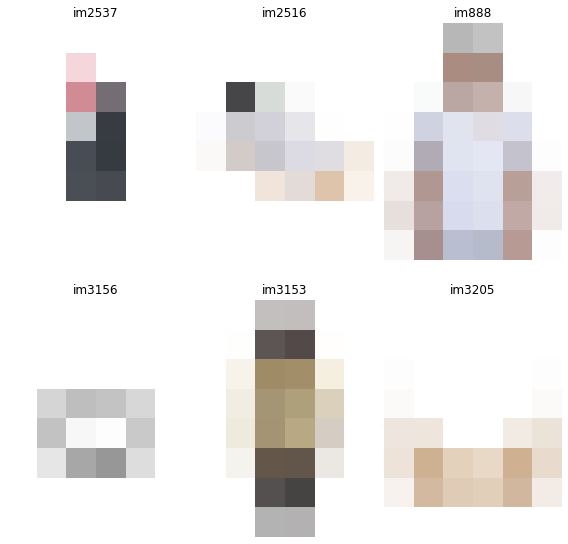

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

<AxesSubplot:>

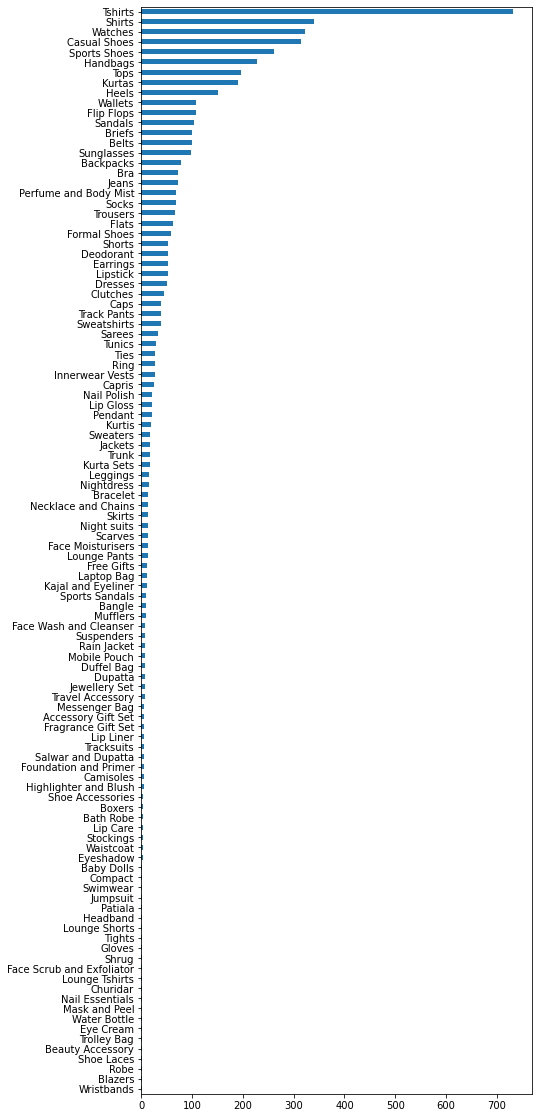

In [22]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [38]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)



# %% [code]
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(2048,)

(8, 6, 3)
[ 2.2286506  6.7580357  0.        ...  2.4853735  2.5894732 18.344503 ]


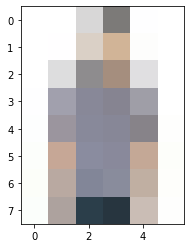

In [39]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [24]:
df.shape


(5000, 11)

In [25]:
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.228651,6.758036,0.000000,1.157926,4.044770,4.190842,7.823339,8.598871,1.214285,0.000000,...,1.759049,5.455353,2.264871,22.648235,0.318425,0.000000,9.307665,2.485373,2.589473,18.344503
1,2.160769,13.004471,0.092261,6.950655,5.372182,0.000000,15.559413,2.178862,0.848540,0.146074,...,2.459621,8.469252,5.472924,8.990248,3.187696,0.256653,7.267735,0.000000,6.571846,17.669712
2,0.000000,2.099401,1.121339,5.048748,2.971097,4.301216,3.864701,1.902131,0.494964,4.596426,...,0.000000,16.961672,2.302290,1.838044,0.741307,0.000000,2.888033,2.204795,5.722476,6.089290
3,0.000000,5.336296,1.670128,11.411585,1.258607,0.000000,12.816566,7.772416,0.845030,2.947617,...,29.042677,1.647542,0.176536,0.000000,6.040610,1.806873,10.376248,0.000000,16.299793,16.499527
4,2.663737,15.295514,0.032797,2.476947,6.908787,2.586334,9.054920,7.316333,0.000000,0.000000,...,2.014317,6.502693,3.596580,19.685740,6.044688,0.000000,8.757937,2.211986,4.258552,17.862123


In [26]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.63644886, 0.4960258 , 0.5943887 ],
       [0.63644886, 1.        , 0.509784  , 0.73752296],
       [0.4960258 , 0.509784  , 1.        , 0.47131705],
       [0.5943887 , 0.73752296, 0.47131705, 0.9999995 ]], dtype=float32)

In [27]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([3349, 259, 1389, 2970, 3678], dtype='int64'),
 [0.90620875, 0.9028229, 0.89971614, 0.8960279, 0.8957297])

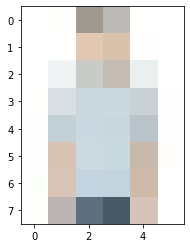

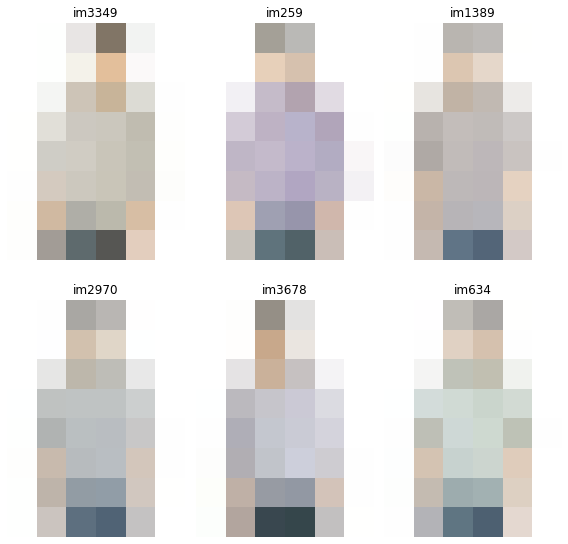

In [28]:
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

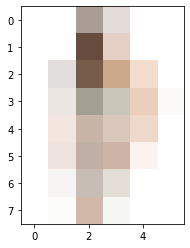

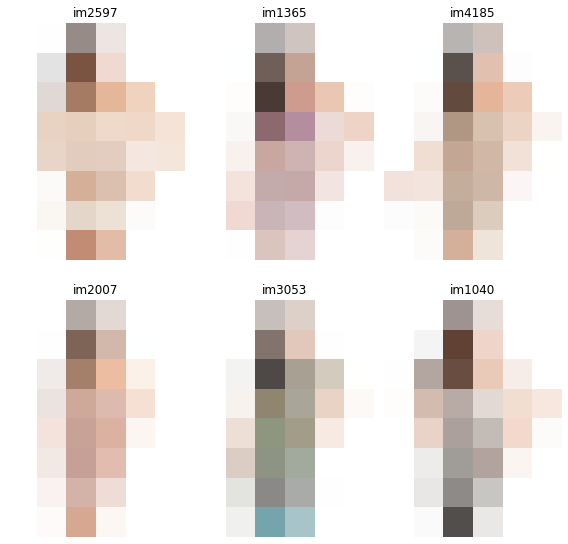

In [31]:
idx_ref = 878

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

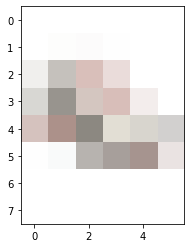

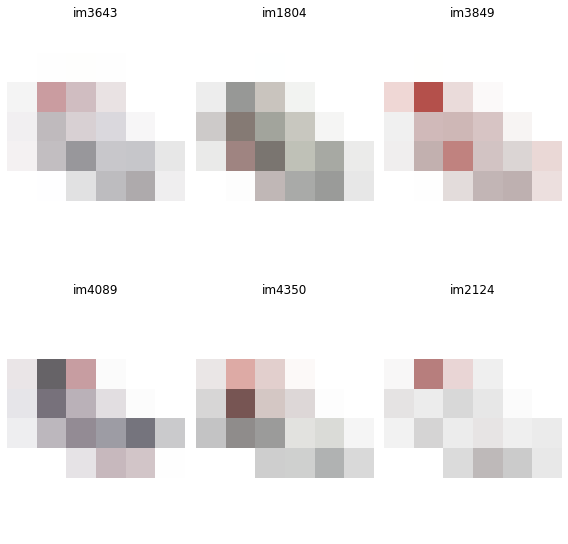

In [32]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

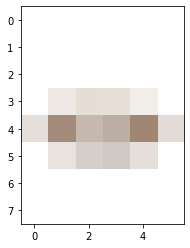

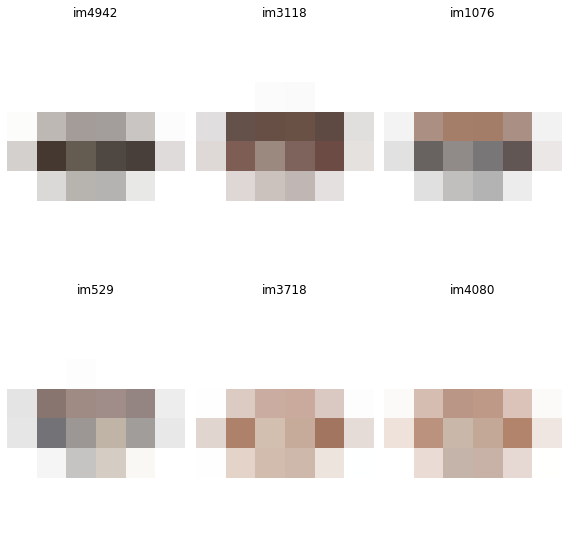

In [33]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [34]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')

In [40]:
pickle.dump(model, open('model.pkl','wb'))

# Loading model to compare the results
load_model = pickle.load(open('model.pkl','rb'))

INFO:tensorflow:Assets written to: ram://e8a5c2f9-746b-4eda-bf5f-e7b34a5648f1/assets


/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
